# Simulations for PMA abstract

In [1]:
from __future__ import annotations

import time as t

import matplotlib.pyplot as plt
import numpy as np
import oawidgets.mtg
from oawidgets.plantgl import *

from openalea.archicrop.display import build_scene, display_scene
from openalea.archicrop.simulation import run_simulations
from openalea.archicrop.stics_io import get_stics_data, read_sti_file
from openalea.plantgl.all import Color3, Material, Scene

%gui qt

In [2]:
tec_file='../data/Mais_tec.xml'
plant_file='../data/corn_plt.xml'
dynamics_file='../data/mod_smaize.sti'
weather_file = '../data/climaisj.meteo'
location = {  
'longitude': 3.87,
'latitude': 45,
'altitude': 800,
'timezone': 'Europe/Paris'}
inter_row = 40 # cm

In [3]:
sowing_density, daily_dynamics, lifespan, lifespan_early = get_stics_data(
    file_tec_xml=tec_file,  # Path to the STICS management XML file
    file_plt_xml=plant_file,  # Path to the STICS plant XML file
    stics_output_file=dynamics_file  # Path to the STICS output file
)
daily_dynamics = read_sti_file(dynamics_file, sowing_density)

# Time series 
# for thermal time, plant leaf area, plant senescent leaf area and plant height
thermal_time = [value["Thermal time"] for value in daily_dynamics.values()]
leaf_area_plant = [value["Plant leaf area"] for value in daily_dynamics.values()]
sen_leaf_area_plant = [value["Plant senescent leaf area"] for value in daily_dynamics.values()]
height_canopy = [value["Plant height"] for value in daily_dynamics.values()]

In [4]:
archi = {
    'nb_phy': [8,20], # number of phytomers on the main stem
    'nb_short_phy': 4,
    
    # Stem
    'height': 3*max(height_canopy), # potential plant height
    'stem_q': 1.0, # parameter for ligule height geometric distribution along axis
    'diam_base': 2.5, # stem base diameter
    'diam_top': 1.5, # stem top diameter

    # Leaf area distribution along the stem  
    'leaf_area': 1.2*max(leaf_area_plant), # potential plant leaf area
    'rmax': [0.55,0.8], # relative position of largest leaf on the stem
    'skew': 0.005, # skewness for leaf area distribution along axis

    # blade area
    'wl': 0.12, # leaf blade width-to-length ratio 
    'klig': 0.6, # parameter for leaf blade shape
    'swmax': 0.55, # relative position of maximal blade width
    'f1': 0.64, # parameter for leaf blade shape
    'f2': 0.92, # parameter for leaf blade shape

    # blade curvature
    'insertion_angle': 35, # leaf blade insertion angle
    'scurv': 0.7, #  relative position of inflexion point
    'curvature': 120, # leaf blade insertion-to-tip angle
    'phyllotactic_angle': 180, # phyllotactic angle
    'phyllotactic_deviation': 10, # half-deviation to phyllotactic angle

    # Development
    'phyllochron': 30, # phyllochron, i.e. stem element appearance rate
    'plastochron': 40, # plastochron, i.e. leaf blade appearance rate

    # Senescence 
    'leaf_lifespan': [lifespan_early, lifespan], # leaf lifespan from appearance

    # Tillering
    'nb_tillers': 0, # number of tillers
    'tiller_delay': 1, # delay, as factor of phyllochron, between the appearance of a phytomer and the appearance of its tiller
    'tiller_angle': 30,
    'reduction_factor': 1, # reduction factor between tillers of consecutive order

    'plant_orientation': 0 #20
}

In [5]:
n_samples=1000
seed=18

In [ ]:
daily_dynamics, params_sets, pot_la, pot_h, realized_la, realized_h, nrj_per_plant, mtgs, filters, sowing_density = run_simulations(
    archi_params=archi, 
    tec_file=tec_file, 
    plant_file=plant_file, 
    dynamics_file=dynamics_file, 
    weather_file=weather_file,
    location=location,
    n_samples=n_samples,
    latin_hypercube=True,
    opt_filter_pot_growth=False,
    opt_filter_realized_growth=True,
    light_inter=False,
    seed=seed,
    inter_row=inter_row)

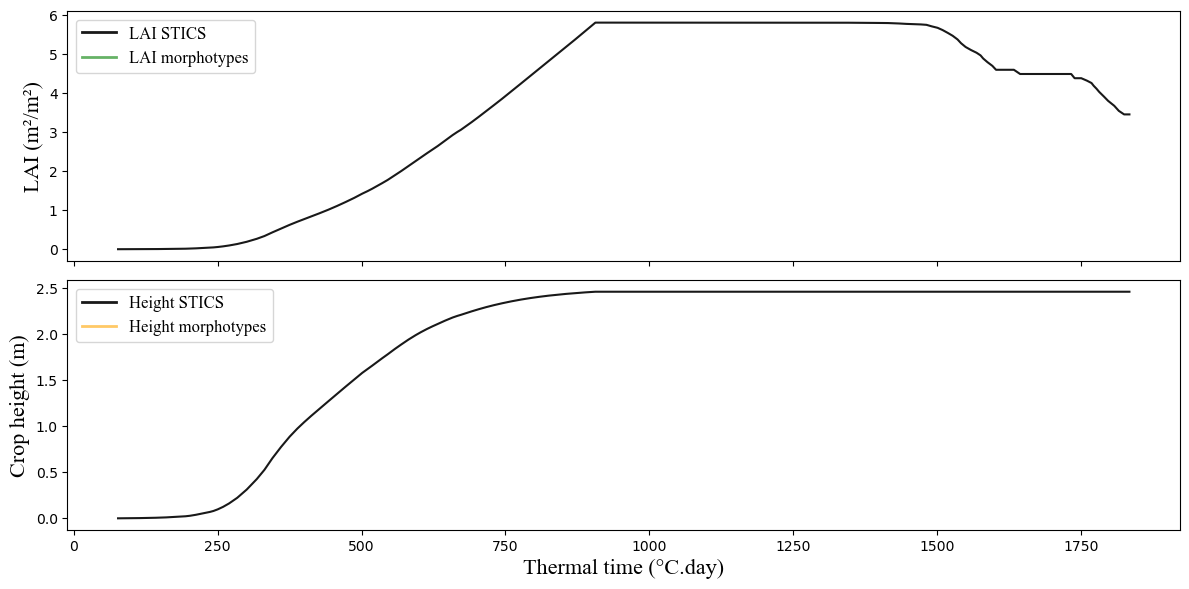

In [ ]:
from matplotlib.lines import Line2D

# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)  # 1 row, 2 columns

# Plot on the first subplot
# for non_result in non_fitting_sim['LA']:
#     axes[0].plot(thermal_time, [r*sowing_density/10000 for r in result],  color="gray", alpha=0.1)
for rla in realized_la.values():
    axes[0].plot(thermal_time, [r*sowing_density/10000 for r in rla],  color="green", alpha=0.6)
    # print(result)
axes[0].plot(thermal_time, [(la-sen)*sowing_density/10000 for la, sen in zip(leaf_area_plant, sen_leaf_area_plant)], color="black", alpha=0.9)
# axes[0].set_xlabel("Thermal time (°C.day)")
axes[0].set_ylabel("LAI (m²/m²)", fontsize=16, fontname="Times New Roman")
# axes[0].set_title("Leaf Area: 3D canopy vs. STICS")
# axes[0].legend(loc=2)

legend_elements_lai = [
    Line2D([0], [0], color='black', alpha=0.9, lw=2, label='LAI STICS'),
    Line2D([0], [0], color='green', alpha=0.6, lw=2, label='LAI morphotypes')
]

axes[0].legend(handles=legend_elements_lai, loc=2, prop={'family': 'Times New Roman', 'size': 12})

# Plot on the second subplot
# for non_result in non_fitting_sim['height']:
#     axes[1].plot(thermal_time, [r*0.01 for r in non_result], color="gray", alpha=0.1)
for rh in realized_h.values():
    axes[1].plot(thermal_time, [r*0.01 for r in rh], color="orange", alpha=0.6)
axes[1].plot(thermal_time, [h*0.01 for h in height_canopy], color="black", alpha=0.9)
axes[1].set_xlabel("Thermal time (°C.day)", fontsize=16, fontname="Times New Roman")
axes[1].set_ylabel("Crop height (m)", fontsize=16, fontname="Times New Roman")
# axes[1].set_title("Plant height: 3D canopy vs. STICS")

legend_elements_height = [
    Line2D([0], [0], color='black', alpha=0.9, lw=2, label='Height STICS'),
    Line2D([0], [0], color='orange', alpha=0.6, lw=2, label='Height morphotypes')
]

axes[1].legend(handles=legend_elements_height, loc=2, prop={'family': 'Times New Roman', 'size': 12})

plt.savefig('PMA_curves')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
scene, _ = build_scene(mtgs[1][60])
PlantGL(scene)

KeyError: 1

## Morphospace

In [ ]:
morpho = {
    i : [p['nb_phy'],p['rmax']]
    for i,p in params_sets.items()
}

# print(morpho)
# print([p['nb_phy'] for p in fitting_sim['params']])
# print([round(p['wl'],2) for p in fitting_sim['params']])

In [ ]:
# Get key with min of the first element
min_first = min(morpho.items(), key=lambda x: x[1][0])[0]
print(morpho[min_first])

# Get key with max of the first element
max_first = max(morpho.items(), key=lambda x: x[1][0])[0]
print(morpho[max_first])

# Get key with min of the second element
min_second = min(morpho.items(), key=lambda x: x[1][1])[0] 
print(morpho[min_second])

# Get key with max of the second element
max_second = max(morpho.items(), key=lambda x: x[1][1])[0]
print(morpho[max_second])

# Collect unique IDs
result_ids = [min_first, max_first, min_second, max_second]

print(result_ids)

[8, 0.7226126428477893]
[18, 0.7956629742139234]
[10, 0.5504690654390973]
[10, 0.7998179341243149]
[8, 18, 424, 13]


In [ ]:
from operator import itemgetter
import heapq

def find_extreme_among_topk(data, primary_index, secondary_index, primary_func, secondary_func, k=3):
    # Extract (key, value) pairs
    items = list(data.items())

    # Get top-k keys by primary metric
    if primary_func == min:
        top_k = heapq.nsmallest(k, items, key=lambda x: x[1][primary_index])
    else:
        top_k = heapq.nlargest(k, items, key=lambda x: x[1][primary_index])

    # From these, find the extreme in secondary metric
    return secondary_func(top_k, key=lambda x: x[1][secondary_index])[0]

key_absmin_relmin = find_extreme_among_topk(morpho, 0, 1, min, min, k=8)
key_absmax_relmin = find_extreme_among_topk(morpho, 0, 1, max, min, k=8)
key_relmin_absmax = find_extreme_among_topk(morpho, 1, 0, min, max, k=8)
key_relmax_absmax = find_extreme_among_topk(morpho, 1, 0, max, max, k=8)

print("Key of [abs min → rel min]:", key_absmin_relmin, morpho[key_absmin_relmin])
print("Key of [abs max → rel min]:", key_absmax_relmin, morpho[key_absmax_relmin])
print("Key of [rel min → abs max]:", key_relmin_absmax, morpho[key_relmin_absmax])
print("Key of [rel max → abs max]:", key_relmax_absmax, morpho[key_relmax_absmax])

result_ids = [key_absmin_relmin, key_absmax_relmin, key_relmin_absmax, key_relmax_absmax]

Key of [abs min → rel min]: 22 [8, 0.5580618434837827]
Key of [abs max → rel min]: 67 [18, 0.714925485820777]
Key of [rel min → abs max]: 498 [13, 0.5520325778835956]
Key of [rel max → abs max]: 31 [18, 0.799166029551244]


In [ ]:
# morpho_list = [fitting_sim['mtg'][id] for id in result_ids]
morpho_list = [mtgs[id] for id in [8, 31, 498]]
for g in morpho_list:
    print(g[120])

MTG : nb_vertices=19, nb_scales=4
MTG : nb_vertices=39, nb_scales=4
MTG : nb_vertices=29, nb_scales=4


In [ ]:
# times = [i for i,t in enumerate(thermal_time) if i%12==0]
times = [27, 35, 50, 70, 100, 150]
# mean_time = sum(times) / len(times)
# positions = [(x, 6*(t-mean_time), z) for x in [0,300] for z in [0,300] for t in times]
ys = [t*5 for t in times]
position = [(0, y, 0) for y in ys]
nice_green = Color3((50, 100, 0))
mtgs = [g for gs in morpho_list for i,g in enumerate(gs) if i in times]
# for i in range(len(mtgs)):
#     print(mtgs[i])
scene1, _ = build_scene(mtgs[0:len(times)], position=position, senescence=True, leaf_material = Material(nice_green), stem_material=Material(nice_green))
scene2, _ = build_scene(mtgs[len(times):len(times)*2], position=position, senescence=True, leaf_material = Material(nice_green), stem_material=Material(nice_green))
scene3, _ = build_scene(mtgs[len(times)*2:len(times)*3], position=position, senescence=True, leaf_material = Material(nice_green), stem_material=Material(nice_green))

In [ ]:
Viewer.display(scene1)

In [ ]:
Viewer.display(scene2)

In [ ]:
Viewer.display(scene3)

In [ ]:
# times = [i for i,t in enumerate(thermal_time) if i%12==0]
times = [28, 38, 50, 100, 150]
# mean_time = sum(times) / len(times)
# positions = [(x, 6*(t-mean_time), z) for x in [0,300] for z in [0,300] for t in times]
ys = [10,120,260,410,610]
position1 = [(0, y, 0) for y in ys]
z2 = 450*(0.8-0.71)/(0.8-0.55)
position2 = [(500, y, z2) for y in ys]
x3 = 500*(18-13)/(18-8)
position3 = [(x3, y, 0) for y in ys]
position4 = [(500, y, 450) for y in ys]
positions = position1 + position2 + position3 + position4
# print(positions)
nice_green = Color3((50, 100, 0))
mtgs = [g for gs in morpho_list for i,g in enumerate(gs) if i in times]
# for i in range(len(mtgs)):
#     print(mtgs[i])
scene, _ = build_scene(mtgs, position=positions, senescence=True, leaf_material = Material(nice_green), stem_material=Material(nice_green))
PlantGL(scene)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [ ]:
from openalea.plantgl.all import *
import numpy as np
from numpy.linalg import norm

def orthonormal_basis(primary):
    if abs(primary[0]) < 0.99:
        tmp = np.array([1, 0, 0])
    else:
        tmp = np.array([0, 1, 0])
    secondary = np.cross(primary, tmp)
    secondary /= norm(secondary)
    return secondary

def orthonormal_basis_from_z(primary_z):
    """
    Génère une base 3D (x, y, z) à partir d'un vecteur z donné.
    """
    z = primary_z / norm(primary_z)
    if abs(z[0]) < 0.99:
        x = np.cross(z, [1, 0, 0])
    else:
        x = np.cross(z, [0, 1, 0])
    x = x / norm(x)
    y = np.cross(z, x)
    return x, y, z

def create_rotation_matrix(direction):
    """
    Crée une matrice de rotation qui aligne l'axe Z sur la direction donnée.
    """
    z = np.array(direction, dtype=float)
    z /= norm(z)
    # Choisir un vecteur qui n'est pas colinéaire à z
    if abs(z[2]) < 0.99:
        up = np.array([0, 0, 1])
    else:
        up = np.array([0, 1, 0])
    x = np.cross(up, z)
    x /= norm(x)
    y = np.cross(z, x)
    return Matrix3(Vector3(*x), Vector3(*y), Vector3(*z))

def create_arrow(origin=(0, 0, 0), direction=(0, 0, 1), length=1.0,
                 shaft_radius=0.001, head_radius=0.005, head_length=0.02,
                 color=(0, 0, 0)):
    """
    Crée une flèche orientée en 3D dans la direction donnée.
    """

    shaft_radius *= length
    head_radius *= length
    head_length *= length

    '''
    # Normaliser direction
    dir_vec = np.array(direction, dtype=float)
    if norm(dir_vec) == 0:
        raise ValueError("La direction ne peut pas être le vecteur nul.")
    dir_vec /= norm(dir_vec)

    # Vecteurs pour Oriented
    primary = Vector3(*dir_vec)
    secondary = Vector3(*orthonormal_basis(dir_vec))

    # Longueur du shaft (tige)
    shaft_len = length - head_length

    # Créer les géométries (dans repère local Z)
    shaft = Cylinder(radius=shaft_radius, height=shaft_len)
    # shaft = Translated((0, 0, shaft_len / 2), shaft)  # placer de base le cylindre

    head = Cone(radius=head_radius, height=head_length)
    head = Translated((0, 0, shaft_len), head)  # placer à la fin

    # Orientation de toute la flèche dans la bonne direction
    oriented_shaft = Oriented(primary, secondary, shaft)
    oriented_head = Oriented(primary, secondary, head)

    # Translation à la position initiale
    final_shaft = Translated(origin, oriented_shaft)
    final_head = Translated(origin, oriented_head)

    # Regrouper
    arrow = Shape(final_shaft, Material(Color3(*color)))
    head_shape = Shape(final_head, Material(Color3(*color)))

    return [arrow, head_shape]
    '''
    shaft_len = length - head_length
    shaft = Cylinder(radius=shaft_radius, height=shaft_len)
    head = Translated((0, 0, shaft_len), Cone(radius=head_radius, height=head_length))
    arrow = Group([shaft, head])
    return arrow

def create_plane(size=1.0, axis='XY', color=(200, 150, 100)):
    half = size / 2
    width = 1

    if axis == 'XY':
        points = [Vector3(-width, -half, 0),
                  Vector3(width, -half, 0),
                  Vector3(width, half, 0),
                  Vector3(-width, half, 0)]
    elif axis == 'XZ':
        points = [Vector3(-half, 0, -half),
                  Vector3(half, 0, -half),
                  Vector3(half, 0, half),
                  Vector3(-half, 0, half)]
    elif axis == 'YZ':
        points = [Vector3(0, -half, -half),
                  Vector3(0, half, -half),
                  Vector3(0, half, half),
                  Vector3(0, -half, half)]
    else:
        raise ValueError("Axis must be 'XY', 'XZ' or 'YZ'")

    # Une face avec les 4 sommets
    indices = [[0, 1, 2, 3]]
    faceset = FaceSet(points, indices)
    return Shape(faceset) #, Material(Color3(*color), transparency=0.5))


# scene = Scene()
origin=(-100, -20, 0)
color=(50,50,50)
color2=(120,90,30)
length=750.0

# Arrows
scene.add(Shape(Translated(origin, Oriented(Vector3((1,0,0)), Vector3((0,1,0)),create_arrow(length=length))), Material(Color3(*color))))
scene.add(Shape(Translated(origin, Oriented(Vector3((0,1,0)), Vector3((0,0,1)),create_arrow(length=length))), Material(Color3(*color))))
scene.add(Shape(Translated(origin, Oriented(Vector3((0,0,1)), Vector3((1,0,0)),create_arrow(length=length))), Material(Color3(*color))))

# Lines
# scene.add(Shape(Translated((-50,-20,0), Oriented(Vector3((0,1,0)), Vector3((0,0,1)),Cylinder(radius=0.01, height=length))), Material(Color3(*color2))))
# scene.add(Shape(Translated((-50,-20,450), Oriented(Vector3((0,1,0)), Vector3((0,0,1)),Cylinder(radius=0.01, height=length))), Material(Color3(*color2))))
# scene.add(Shape(Translated((0,-20,0), Oriented(Vector3((1,0,0)), Vector3((0,1,0)),Cylinder(radius=0.01, height=length))), Material(Color3(*color2))))
# scene.add(Shape(Translated((500,-20,0), Oriented(Vector3((1,0,0)), Vector3((0,1,0)),Cylinder(radius=0.01, height=length))), Material(Color3(*color2))))
# z 450 
# x 500 + 50

# Plane
scene.add(Shape(Translated((0,375-20,0), Oriented(Vector3((1,0,0)), Vector3((0,1,0)),create_plane(size=750).geometry)), Material(Color3(*color2), transparency=0.8)))
scene.add(Shape(Translated((x3,375-20,0), Oriented(Vector3((1,0,0)), Vector3((0,1,0)),create_plane(size=750).geometry)), Material(Color3(*color2), transparency=0.8)))
scene.add(Shape(Translated((500,375-20,450), Oriented(Vector3((1,0,0)), Vector3((0,1,0)),create_plane(size=750).geometry)), Material(Color3(*color2), transparency=0.8)))
scene.add(Shape(Translated((500,375-20,z2), Oriented(Vector3((1,0,0)), Vector3((0,1,0)),create_plane(size=750).geometry)), Material(Color3(*color2), transparency=0.8)))
          
Viewer.display(scene)
